In [ ]:
%pip install matplotlib
%pip install seaborn

In [ ]:
%pip install sentence_transformers

In [5]:
import aiohttp
import asyncio


async def fetch_api( age, gene_fault, llm, category, patient_question):
    async with aiohttp.ClientSession() as session:
        link = "http://127.0.0.1:8000/chat"
        payload = {
                "age" : age,
                "gene_fault": gene_fault,
                "llm": llm,
                "category": category,
                "patient_question": patient_question
            }
        resp = await session.post( link, json=payload  )
        
        try:
            data = await resp.json()
            # print("Response JSON:", data)
            return data
        except aiohttp.ContentTypeError:
            text = await resp.text()
            # print("Response Text:", text)
            return text
        

In [6]:
mistral = await fetch_api( 50, "BRCA1", "mistral", "breast_cancer", "What is the best treatment for me?" )
deepseek = await fetch_api( 50, "BRCA1", "deepseek", "breast_cancer", "What is the best treatment for me?" )
openai = await fetch_api( 50, "BRCA1", "openai", "breast_cancer", "What is the best treatment for me?" )


In [33]:
import json
with open("mistral_response.json", "w", encoding="utf-8") as f:
    json.dump(mistral, f, indent=2, ensure_ascii=False)
    
with open("deepseek_response.json", "w", encoding="utf-8") as f:
    json.dump(deepseek, f, indent=2, ensure_ascii=False)
    
with open("openai_response.json", "w", encoding="utf-8") as f:
    json.dump(openai, f, indent=2, ensure_ascii=False)

In [28]:
def llm_response( path ):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data

In [35]:
mistra_path = "mistral_response.json"
mistra_res_json = llm_response(mistra_path)

deepseek_path = "deepseek_response.json"
deepseek_res_json = llm_response(deepseek_path)

opeai_path = "openai_response.json"
openai_res_json = llm_response(opeai_path)
            


In [37]:
openai_res_json

{'output': 'For someone who is 30 years old and has a BRCA2 gene fault, the risk of developing breast cancer between ages 25 and 30 is approximately 1-2%. The risk of ovarian cancer by this age is generally low but tends to increase after age 40. Other cancers associated with BRCA2 mutations, such as male breast cancer, prostate cancer, and pancreatic cancer, typically have risks that become more relevant at older ages beyond 30.  \n\nWhile the risk of breast cancer at your current age is relatively low, it is not zero, so regular surveillance and discussions about risk management with healthcare professionals or a genetic counselor are recommended. This can help ensure early detection and preventive measures if necessary.  \n\nIf you have further concerns or want tailored advice, seeking guidance from a genetic counselor or specialist is strongly advised.  \n\nHeading: Resources  \n- Detailed, age-specific risk data and management guidelines are often provided by genetic counseling se

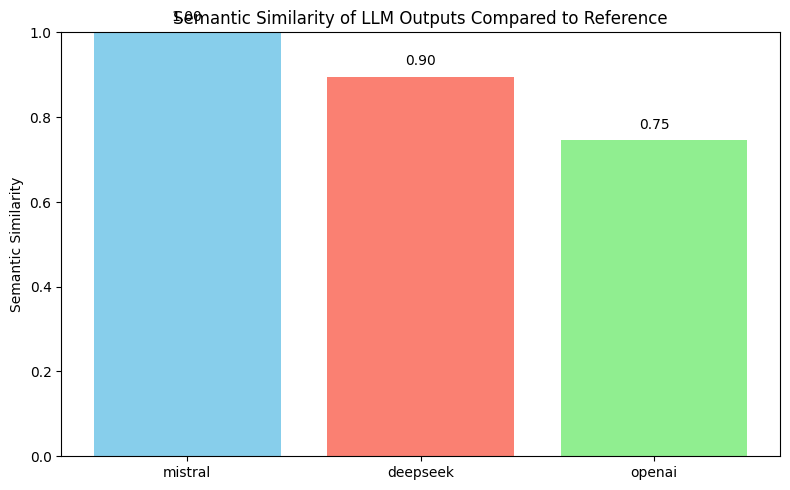

In [38]:
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt

# Load a BERT-based model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight, fast BERT variant

# Reference answer and LLM outputs
reference_text = mistra_res_json["output"]
llm_outputs = {
    "mistral":  mistra_res_json["output"],
    "deepseek": deepseek_res_json["output"],
    "openai":   openai_res_json["output"]
}

# Create a list of texts: [reference, llm_1, llm_2, ...]
texts = [reference_text] + list(llm_outputs.values())

# Get BERT embeddings
embeddings = model.encode(texts, convert_to_tensor=True)

# Compute cosine similarities between reference and each LLM output
similarities = {
    name: util.cos_sim(embeddings[0], embeddings[i + 1]).item()
    for i, name in enumerate(llm_outputs)
}

# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(similarities.keys(), similarities.values(), color=['skyblue', 'salmon', 'lightgreen'])
plt.ylim(0, 1)
plt.ylabel("Semantic Similarity")
plt.title("Semantic Similarity of LLM Outputs Compared to Reference")

# Annotate bars with values
for bar in bars:
    score = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, score + 0.02, f"{score:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()
